In [2]:
from appgeopy import *
from my_packages import *

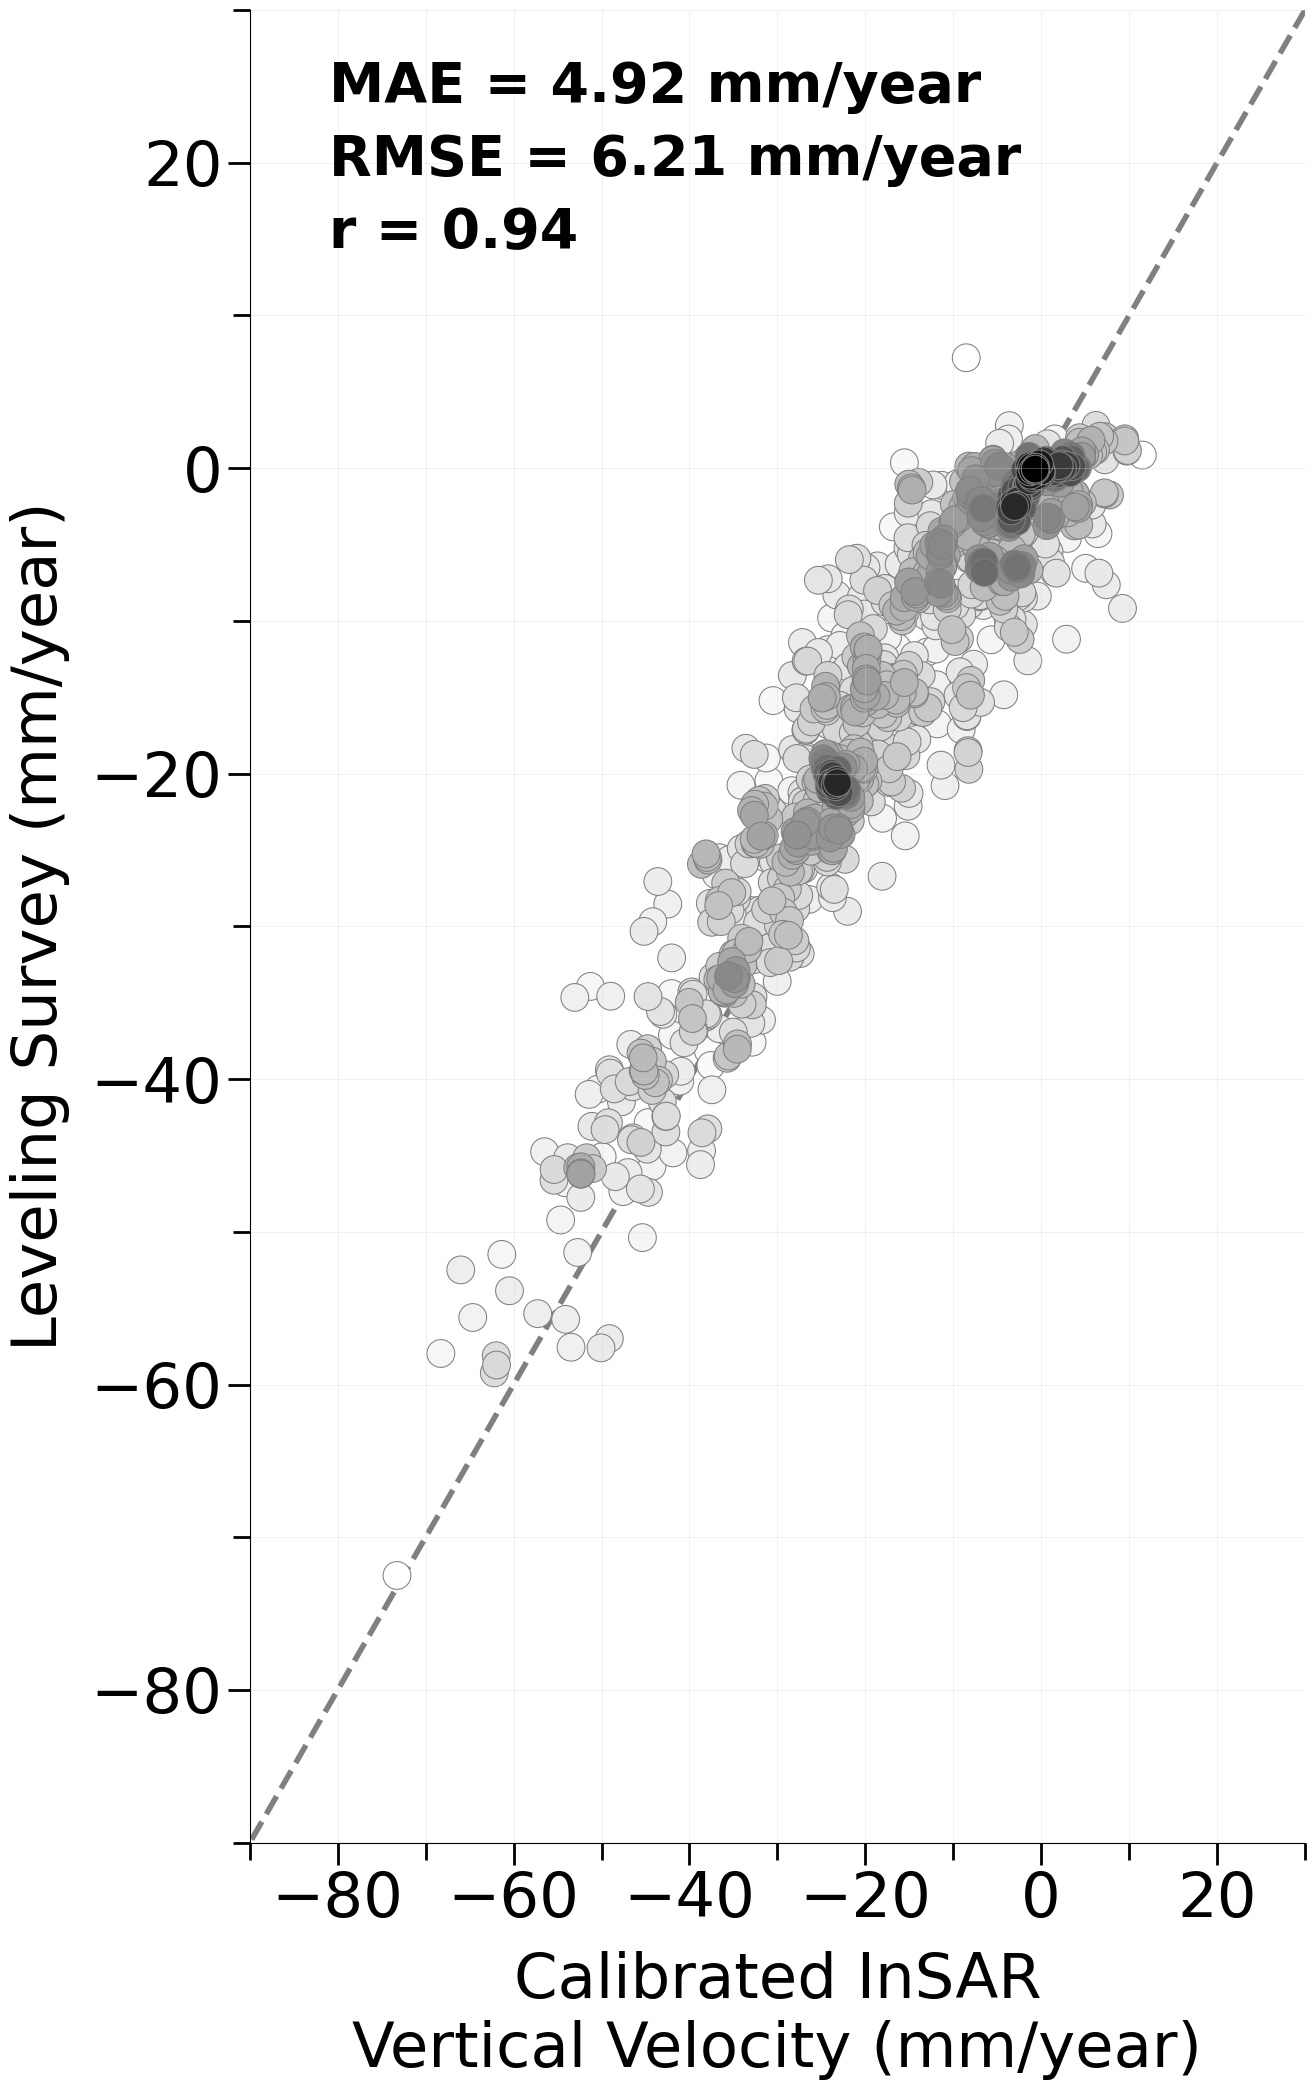

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.ticker as plticker
from matplotlib.cm import ScalarMappable 

# Load data from Excel
filepath = r"D:\1000_SCRIPTS\002_Manuscript_1\17_VERTICAL\All_InSAR_Leveling_Comparison.xlsx"
df = pd.read_excel(filepath)

# Set the base name for saving figures
base = "Leveling_InSAR_VERT_Calibrated"
figSave = True

# Set up the figure size and axis
cm = 1 / 2.54
multiplier = 2.5
fig, ax = plt.subplots(figsize=(5.3 * multiplier, 8.4 * multiplier))

# Set grid and diagonal reference line
ax.grid(axis="both", which="both", color="lightgrey", alpha=0.3)
top_thres = 30
bot_thres = -90
x1, y1 = [top_thres, bot_thres], [top_thres, bot_thres]
ax.plot(x1, y1, linestyle="--", color="gray", linewidth=4, zorder=1)

# Define x and y data
x_axis_object = "PSC_AvgVel"
y_axis_object = "LEV_AvgVel"
df["ABS"] = abs(df[x_axis_object] - df[y_axis_object])
df = df.query("ABS <= 20")

x = df[x_axis_object].to_numpy()  # Convert pandas Series to numpy array
y = df[y_axis_object].to_numpy()  # Convert pandas Series to numpy array

# Create a density scatter plot
def density_scatter(x, y, ax=None, sort=True, bins=20, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    # 2D histogram to calculate density
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=True)

    # Interpolate density values for the scatter points
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)

    # Handle NaN values (set them to zero)
    z[np.isnan(z)] = 0.0

    # Sort points by density (densest plotted last for visibility)
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    # Create scatter plot, color-coded by density
    scatter = ax.scatter(x, y, c=z, cmap="gray_r", s=400, edgecolor='gray', linewidths=0.75)

    # Add color bar
    # norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    # cbar = ax.get_figure().colorbar(ScalarMappable(norm=norm, cmap="viridis"), ax=ax)
    # cbar.ax.set_ylabel("Density")

    return ax

# Call the density scatter plot function
density_scatter(x, y, ax=ax, bins=50)

# Set grid, limits, and thresholds for the plot
ax.grid(axis="both", which="both", color="lightgrey", alpha=0.3)  # Adjust grid appearance
top_thres = 30  # Upper limit for axes
bot_thres = -90  # Lower limit for axes
ax.set_xlim(bot_thres, top_thres)
ax.set_ylim(bot_thres, top_thres)


# Set axis labels
ax.set_xlabel("Calibrated InSAR\nVertical Velocity (mm/year)", fontsize=45, labelpad=15)
ax.set_ylabel("Leveling Survey (mm/year)", fontsize=45, labelpad=15)

# Compute statistics: MAE, RMSE, correlation
mean_abs_err = np.mean(np.abs(x - y))
rmse = np.sqrt(np.mean((x - y) ** 2))
m, c, r, p, se1 = stats.linregress(x, y)

# Add text annotations for errors and correlation
ax.text(0.075, 0.95, f"MAE = {mean_abs_err:.2f} mm/year", transform=ax.transAxes, fontweight="bold", fontsize=40)
ax.text(0.075, 0.91, f"RMSE = {rmse:.2f} mm/year", transform=ax.transAxes, fontweight="bold", fontsize=40)
ax.text(0.075, 0.87, f"r = {r:.2f}", transform=ax.transAxes, fontweight="bold", fontsize=40)

# Set major and minor ticks
major_base = 20
minor_base = 10
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=major_base))
ax.xaxis.set_minor_locator(plticker.MultipleLocator(base=minor_base))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=major_base))
ax.yaxis.set_minor_locator(plticker.MultipleLocator(base=minor_base))

# Customize tick parameters
ax.tick_params(axis="both", which="major", labelsize=45, direction="out", length=16, width=2)
ax.tick_params(axis="both", which="minor", labelsize=45, direction="out", length=12, width=2)

# Remove unnecessary spines for cleaner plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Tight layout for saving the figure
fig.tight_layout()

# Save the figure with incremental file name
folder2savefigure = os.getcwd()
for i in range(1, 1001):
    savename = os.path.join(folder2savefigure, base + "_{}.png".format(str(i).zfill(3)))
    if not os.path.exists(savename):
        break

if figSave:
    plt.savefig(savename, dpi=600, transparent=False, facecolor="w", edgecolor="w", bbox_inches="tight")

plt.show()
